In [1]:
import random
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import svd
from scipy.spatial.transform import Rotation as R
from tqdm import tqdm


np.set_printoptions(precision=3, floatmode='fixed')

### №8

In [2]:
def generate_homography_matrix():
    theta = np.random.uniform(-np.pi, np.pi)
    R = np.array([[np.cos(theta), -np.sin(theta), 0], 
                  [np.sin(theta), np.cos(theta), 0],
                  [0, 0, 1]])
    sx, sy = np.random.uniform(0.5, 2, size=2)
    S = np.array([[sx, 0, 0],
                  [0, sy, 0],
                  [0, 0, 1]])
    tx, ty = np.random.uniform(-0.5, 0.5, size=2)
    T = np.array([[1, 0, tx],
                  [0, 1, ty],
                  [0, 0, 1]])
    return np.linalg.inv(T @ S @ R @ np.linalg.inv(T))

def point_pair_generator(H, n=1000, p_inliers=0.3):
    lst1 = np.column_stack((np.random.randint(-10, 10, size=n), np.random.randint(-10, 10, size=n), np.ones(n)))
    n_inliers = int(n * p_inliers)
    n_outliers = n - n_inliers
    lst2_inliers = H @ lst1[:n_inliers, :].T
    if np.any(np.isclose(lst2_inliers[2], 0)):
        raise ValueError("Division by zero")
    lst2_inliers /= lst2_inliers[2]
    lst2_outliers = np.column_stack((np.random.randint(-10, 10, size=(n_outliers, 2)), np.ones(n_outliers)))
    lst2 = np.concatenate((lst2_inliers.T, lst2_outliers), axis=0)
    return lst1, lst2

def dlt(pts1, pts2):
    n_points = pts1.shape[0]
    A = np.zeros((2 * n_points, 9))
    for i in range(n_points):
        x, y, _ = pts1[i]
        u, v, _ = pts2[i]
        A[2 * i] = [-x, -y, -1, 0, 0, 0, x * u, y * u, u]
        A[2 * i + 1] = [0, 0, 0, -x, -y, -1, x * v, y * v, v]
    _, _, V = np.linalg.svd(A)
    H = V[-1].reshape((3, 3))
    H /= H[2, 2]
    return H

def find_homography_RANSAC(pts1, pts2, threshold=1, n_iters=1000):
    best_H = None
    best_inliers = []
    for i in range(n_iters):
        indices = random.sample(range(len(pts1)), 4)
        H = dlt(pts1[indices], pts2[indices])
        inliers = []
        for j in range(len(pts1)):
            t_point = H @ pts1[j]
            if t_point[2] == 0:
                continue
            t_point /= t_point[2]
            if np.linalg.norm(t_point - pts2[j]) < threshold:
                inliers.append(j)
        if len(inliers) > len(best_inliers):
            best_inliers = inliers
            best_H = H
    return best_H

In [3]:
H0 = generate_homography_matrix()
pts1, pts2 = point_pair_generator(H0)
H1 = find_homography_RANSAC(pts1, pts2)

print("H0:")
print(H0)
print("H1:")
print(H1)

H0:
[[-0.161  1.713  0.087]
 [-0.507 -0.545 -0.301]
 [ 0.000  0.000  1.000]]
H1:
[[-1.613e-01  1.713e+00  8.660e-02]
 [-5.071e-01 -5.450e-01 -3.007e-01]
 [-5.962e-17  1.490e-16  1.000e+00]]


### №10

In [4]:
fx = 400
fy = 400
cx = 960
cy = 540
K = np.array([[fx, 0, cx],
              [0, fy, cy],
              [0, 0, 1]], dtype=np.float32)

angle = np.pi / 4
r = R.from_rotvec([0, 0, angle]).as_matrix()
t = np.array([0, 0, 10], dtype=np.float32)

RT = np.hstack((r.T, - r.T @ t.reshape(3, 1)))
P = K @ RT
print(f"Projection matrix: \n{P}")

Projection matrix: 
[[ 2.828e+02  2.828e+02  9.600e+02 -9.600e+03]
 [-2.828e+02  2.828e+02  5.400e+02 -5.400e+03]
 [ 0.000e+00  0.000e+00  1.000e+00 -1.000e+01]]


In [5]:
cell_size = 0.2
board_size = (7, 7)
n_corners = (board_size[0]) * (board_size[1])

corners_3d = np.zeros((n_corners, 3), np.float32)
corners_3d[:, :2] = np.mgrid[0:board_size[0], 0:board_size[1]].T.reshape(-1, 2) * cell_size

corners_2d, _ = cv2.projectPoints(corners_3d, r, t, K, None)
_, rvec, tvec, _ = cv2.solvePnPGeneric(corners_3d, corners_2d.reshape(-1, 2), K, None)
R = R.from_rotvec(np.array(rvec)[0, :, 0]).as_matrix()
RT_PnP = np.hstack((R, np.array(tvec).reshape(-1, 1)))

print(f"[R|T] matrix from №6: \n{RT}")
print(f"[R|T] matrix: \n{RT_PnP}")

[R|T] matrix from №6: 
[[  0.707   0.707   0.000   0.000]
 [ -0.707   0.707   0.000   0.000]
 [  0.000   0.000   1.000 -10.000]]
[R|T] matrix: 
[[ 7.071e-01 -7.071e-01 -1.061e-10  6.354e-12]
 [ 7.071e-01  7.071e-01 -6.395e-06 -2.027e-07]
 [ 4.522e-06  4.522e-06  1.000e+00  1.000e+01]]


Разница в знаках объясняется тем, что в `задаче 6` мы имеем преобразование от мировой системы координат к системе координат связанной с камерой, а сейчас наоборот.

### №11

In [6]:
board_size = (9, 6)

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

objp = np.array([(i, j, 0) for j in range(board_size[1]) for i in range(board_size[0])], np.float32)

objpoints = []
imgpoints = []

images = glob.glob('calibration5/*.jpg')

for fname in tqdm(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, board_size, None)

    if ret:
        objpoints.append(objp)
        corners2 = cv2.cornerSubPix(gray, corners, (7, 7), (-1,-1), criteria)
        imgpoints.append(corners2)

_, mtx, dist, _, _ = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

print("Матрица калибровки:\n", mtx)
print("\nКоэффициенты дисторсии:\n", dist)

100%|██████████| 1369/1369 [03:57<00:00,  5.76it/s]

Матрица калибровки:
 [[430.089   0.000 482.884]
 [  0.000 438.873 268.776]
 [  0.000   0.000   1.000]]

Коэффициенты дисторсии:
 [[-2.071e-01 -9.044e-01 -2.461e-03  1.045e-03  6.846e+00]]


### №12

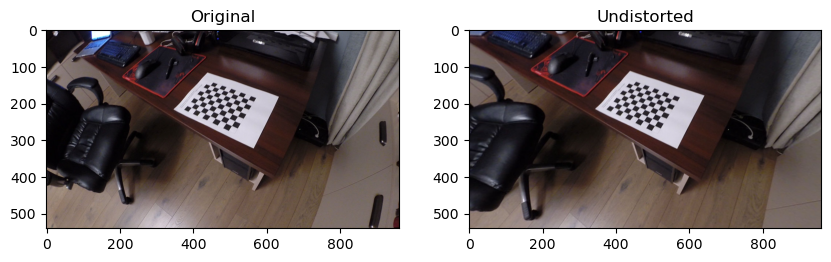

In [7]:
fs = cv2.FileStorage('camera.xml', cv2.FILE_STORAGE_READ)
cameraMatrix = fs.getNode('camera_matrix').mat()
distCoeffs = fs.getNode('distortion_coefficients').mat()

src = cv2.imread('GOPR01170000.jpg')

dst = cv2.undistort(src, cameraMatrix, distCoeffs)
cv2.imwrite('undst_GOPR01170000.jpg', dst)

fig, axs = plt.subplots(1, 2, figsize=(10, 10))
axs[0].imshow(cv2.cvtColor(src, cv2.COLOR_BGR2RGB))
axs[0].set_title('Original')
axs[1].imshow(cv2.cvtColor(np.uint8(dst), cv2.COLOR_BGR2RGB))
axs[1].set_title('Undistorted')
plt.show()